<a href="https://colab.research.google.com/github/priyanshiyadavnitsgr/Computer-Vision/blob/master/homography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

In [0]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [0]:
image=cv2.imread('/content/IMG_20191003_140357.jpg')
cv2_imshow(image)

In [7]:
image.shape

(3000, 4000, 3)

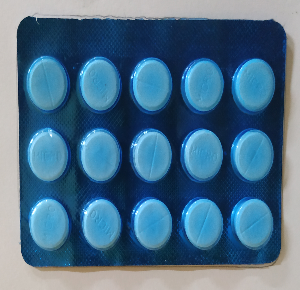

In [8]:
original=cv2.resize(image, (500,500))[40:330,120:-80]
cv2_imshow(original)

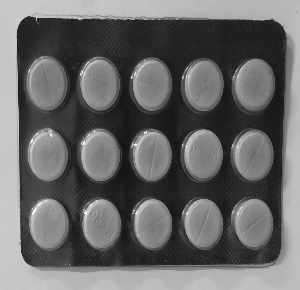

(290, 300)

In [84]:
template=cv2.cvtColor(original.copy(), cv2.COLOR_BGR2GRAY)
cv2_imshow(template)
template.shape

In [0]:

## Resize the images to a default shape of (500,500)
def resize_image(image, size=(500,500)):
  image_resize=cv2.resize(image, (500,500))
  #cv2_imshow(image_resize)
  return image_resize
  
  
## Convert the images to gray scale
  
def gray_image(image):
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


## Detects the objects

def object_detection(image, template, width=300, height=290):
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  
    result=cv2.matchTemplate(image_gray, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc= cv2.minMaxLoc(result)
    print(' Accuracy: ', max_val, '\n Location: ', max_loc)
    
    top_left=max_loc
    bottom_right=(top_left[0]+width, top_left[1]+height)
    detected=cv2.rectangle(image.copy(), top_left, bottom_right, (0,0,255), 4)

    cv2_imshow( detected)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows() 
    
    return detected
  
  
## Crops out the best matching
  
def crop_detected_object (image, template, width=300, height=290):
    image_gray=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  

    result=cv2.matchTemplate(image_gray, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc= cv2.minMaxLoc(result)
    print(' Accuracy: ', max_val,'\n Location of the image: ',  max_loc)

    top_left=max_loc
    bottom_right=(top_left[0]+width, top_left[1]+height)

    cropped=image[ top_left[1]:top_left[1]+height, top_left[0]:top_left[0]+width]
    cv2_imshow(cropped)

    return cropped 
  
  
## Draws contours around the image 
def contour_mapping(med):
  gray=cv2.cvtColor(med, cv2.COLOR_BGR2GRAY)

  gaussian=cv2.GaussianBlur(gray, (11,11), 0)
  ret,thresh1 = cv2.threshold(gaussian, 15, 255, cv2.THRESH_TOZERO)
  edged=cv2.Canny(thresh1, 100, 100)

  cv2_imshow(edged)

  _, contours, _= cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contour_list = []
  for contour in contours:
      approx = cv2.approxPolyDP(contour,0.05*cv2.arcLength(contour,True),True)
      area = cv2.contourArea(contour)
      if ((len(approx) > 2) & (area > 5) ):
          contour_list.append(contour)
        
  print(len(contour_list))
  cv2.drawContours(med, contour_list,  -1, (255,0,0), 2)
  cv2_imshow(med)
  
  return edged

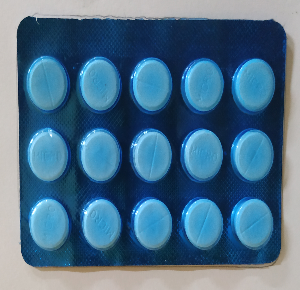

In [11]:
all_pills=resize_image(image=cv2.imread('/content/IMG_20191003_140357.jpg'))[40:330,120:-80]
print('\n')
cv2_imshow(all_pills)

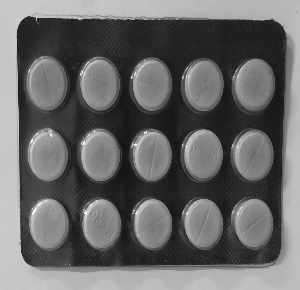

In [12]:
temp= gray_image(all_pills)


 Accuracy:  0.9055680632591248 
 Location of the image:  (0, 0)


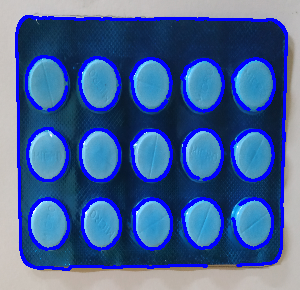

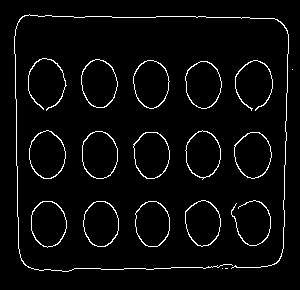

28


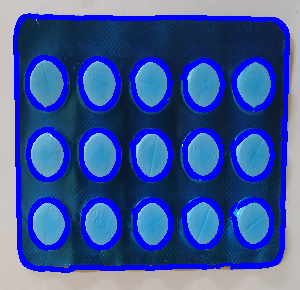

In [71]:
detected_all=crop_detected_object(all_pills, template)
contour_all=contour_mapping(detected_all)

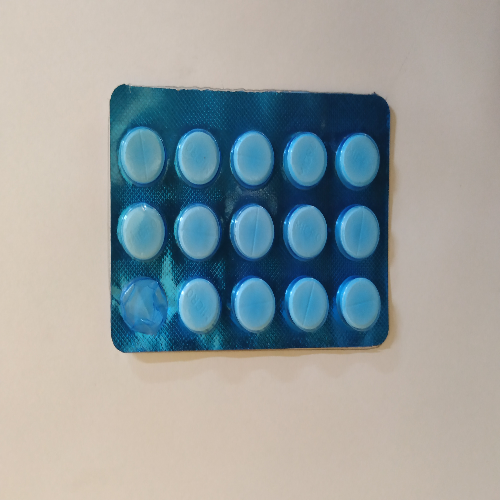

In [49]:
one_missing=resize_image(image=cv2.imread('/content/one_.jpg'))
cv2_imshow(one_missing)

 Accuracy:  0.7406290769577026 
 Location of the image:  (101, 77)


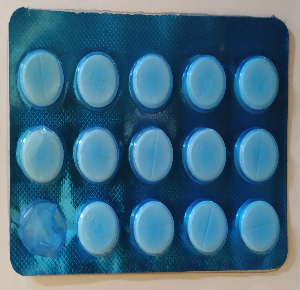

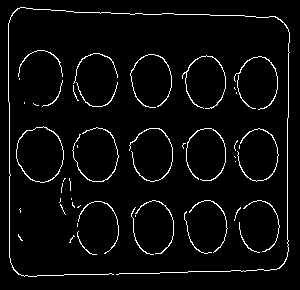

23


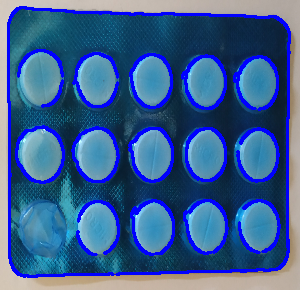

In [15]:
detected_one_missing=crop_detected_object(one_missing, template)
contour_one=contour_mapping(detected_one_missing)

In [0]:
tilted=resize_image(cv2.imread('/content/rotated.jpg'))

In [0]:
def homography_of_images(template, image):
  sift = cv2.xfeatures2d.SIFT_create()
  kp_image, desc_image = sift.detectAndCompute(template, None)
# Feature matching
  index_params = dict(algorithm=0, trees=5)
  search_params = dict()
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  
  grayframe = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # trainimage
  kp_grayframe, desc_grayframe = sift.detectAndCompute(grayframe, None)
  matches = flann.knnMatch(desc_image, desc_grayframe, k=2)
  good_points = []
  for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_points.append(m)
        
  query_pts = np.float32([kp_image[m.queryIdx].pt for m in good_points]).reshape(-1, 1, 2)
  train_pts = np.float32([kp_grayframe[m.trainIdx].pt for m in good_points]).reshape(-1, 1, 2)
  matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)
  matches_mask = mask.ravel().tolist()
  
  
  h, w = template.shape[:2]
  pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
  print (pts, matrix, pts.shape, matrix.shape, good_points)
  dst = cv2.perspectiveTransform(pts, matrix)
  
  
  homography = cv2.polylines(image, [np.int32(dst)], True, (0, 0, 0), 3)
  cv2_imshow( homography)
  

[[[  0.   0.]]

 [[  0. 290.]]

 [[300. 290.]]

 [[300.   0.]]] [[ 1.11944117e+00 -5.46774570e-02  9.27909700e+01]
 [ 5.41640438e-02  1.00399412e+00  6.89881997e+01]
 [ 2.24046035e-04 -2.01347857e-04  1.00000000e+00]] (4, 1, 2) (3, 3) [<DMatch 0x7f0afcc97bd0>, <DMatch 0x7f0afcc97050>, <DMatch 0x7f0afcc97eb0>, <DMatch 0x7f0afcc97f10>, <DMatch 0x7f0afcc97250>, <DMatch 0x7f0afcc975b0>, <DMatch 0x7f0afcc97e50>, <DMatch 0x7f0afcc973b0>, <DMatch 0x7f0afcc97430>, <DMatch 0x7f0afcc97e70>, <DMatch 0x7f0afcc970b0>, <DMatch 0x7f0afcc97c70>, <DMatch 0x7f0afcc97d50>, <DMatch 0x7f0afcc97ed0>, <DMatch 0x7f0afcc97410>, <DMatch 0x7f0afcc32cd0>, <DMatch 0x7f0afcc32f90>, <DMatch 0x7f0afcc32b30>, <DMatch 0x7f0afcc327f0>, <DMatch 0x7f0afcc32b70>, <DMatch 0x7f0afcc32d50>, <DMatch 0x7f0afcc32fd0>, <DMatch 0x7f0afcc32110>, <DMatch 0x7f0afcc32a50>, <DMatch 0x7f0afcc32a70>, <DMatch 0x7f0afcc32990>, <DMatch 0x7f0afcc32750>, <DMatch 0x7f0afcc32e50>, <DMatch 0x7f0afcc32130>, <DMatch 0x7f0afcc32bd0>, <DMatch 0x7f0a

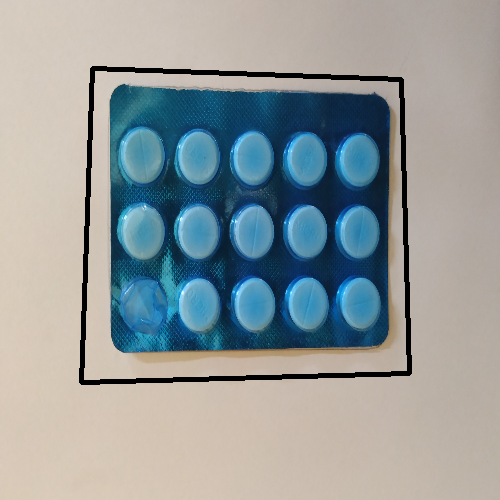

In [181]:
template=cv2.cvtColor(original.copy(), cv2.COLOR_BGR2GRAY)

one_missing=resize_image(image=cv2.imread('/content/one_.jpg'))
homography_of_images(template, one_missing)
#homography_of_images(template, )

[[[  0.   0.]]

 [[  0. 290.]]

 [[300. 290.]]

 [[300.   0.]]] [[ 1.01261806e+00 -4.70276855e-02  1.30299037e+02]
 [ 5.03794743e-02  9.89024105e-01  7.64299284e+01]
 [ 1.04467663e-05 -6.43681968e-05  1.00000000e+00]] (4, 1, 2) (3, 3) [<DMatch 0x7f0afcc32990>, <DMatch 0x7f0afcc32e50>, <DMatch 0x7f0afcc32b10>, <DMatch 0x7f0afcc328f0>, <DMatch 0x7f0afcc32eb0>, <DMatch 0x7f0afcc32ed0>, <DMatch 0x7f0afcc32ad0>, <DMatch 0x7f0afcc32c70>, <DMatch 0x7f0afcc326f0>, <DMatch 0x7f0afcc32c10>, <DMatch 0x7f0afcc32830>, <DMatch 0x7f0afcc32170>, <DMatch 0x7f0afcc32bf0>, <DMatch 0x7f0afcc32f30>, <DMatch 0x7f0afcc32870>, <DMatch 0x7f0afcc321b0>, <DMatch 0x7f0afcc32e90>, <DMatch 0x7f0afcc320b0>, <DMatch 0x7f0afcec6ad0>, <DMatch 0x7f0afcec6c90>, <DMatch 0x7f0afcec6d50>, <DMatch 0x7f0afcec6d70>, <DMatch 0x7f0afcec6e10>, <DMatch 0x7f0afcec6c10>, <DMatch 0x7f0afcec6a70>, <DMatch 0x7f0afcec6ab0>, <DMatch 0x7f0afcc97e70>, <DMatch 0x7f0afcc97ed0>, <DMatch 0x7f0afcc975d0>, <DMatch 0x7f0afcc97ab0>, <DMatch 0x7f0a

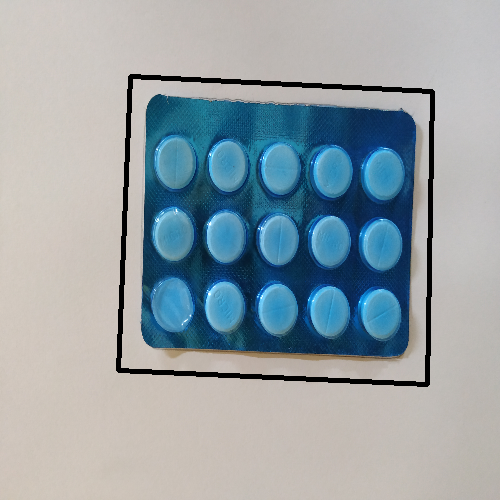

In [182]:
changed=resize_image(image=cv2.imread('/content/IMG_20191003_143217.jpg'))

homography_of_images(template, changed)

[[[  0.   0.]]

 [[  0. 290.]]

 [[300. 290.]]

 [[300.   0.]]] [[ 1.87289088e+00 -1.41901770e+00  2.18589723e+02]
 [ 1.65856698e+00 -7.55341827e-01  9.86259901e+01]
 [ 8.72022712e-03 -6.48796521e-03  1.00000000e+00]] (4, 1, 2) (3, 3) [<DMatch 0x7f0afe736a90>, <DMatch 0x7f0afe736790>, <DMatch 0x7f0afe7331b0>, <DMatch 0x7f0afe733270>, <DMatch 0x7f0afccaf0d0>, <DMatch 0x7f0afccaf6d0>, <DMatch 0x7f0afcc919d0>, <DMatch 0x7f0afcc91ad0>, <DMatch 0x7f0afcc91b90>, <DMatch 0x7f0afcc91cf0>]


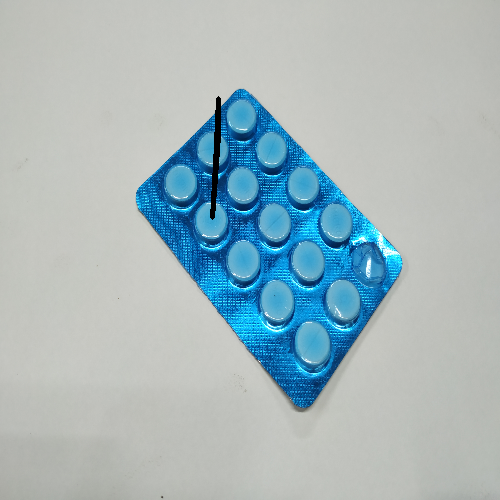

In [190]:
new=cv2.resize(cv2.imread('/content/rotated.jpg'), (500, 500))

homography_of_images(template, new)

In [0]:
new=cv2.resize(cv2.imread('/content/IMG_20191004_153244.jpg'), (500, 500))

homography_of_images(template, new)

In [0]:
new=cv2.resize(cv2.imread('/content/IMG_20191004_160942.jpg'), (500, 500))


homography_of_images(template, crop_detected_object(new, template))

In [197]:
!pip install matplotlib

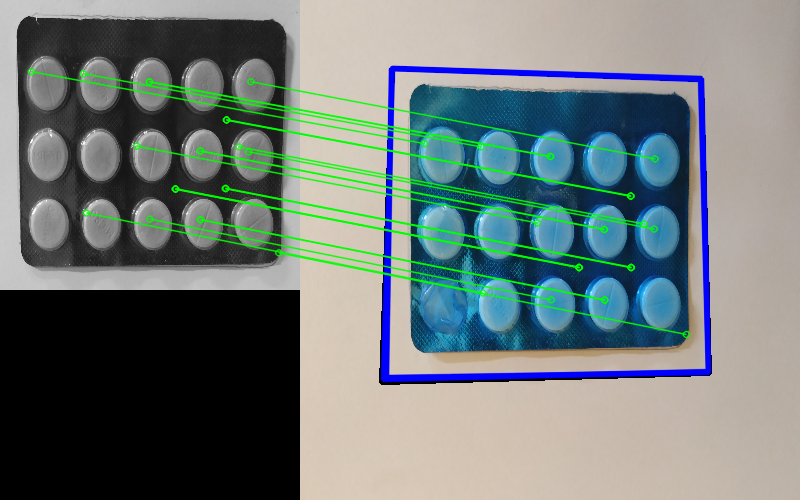

[-10.09576111 -11.39022681  -4.58623394]
[-10.09576111 -11.39022681  -4.58623394]
[-3.52438864  3.94975608 -1.27737921]
[-3.52438864  3.94975608 -1.27737921]


In [210]:
import math

img1 = template
img2 = one_missing


#Feature Extraction
MIN_MATCH_COUNT = 10
sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.80*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    #Finds homography matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,1)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

cv2_imshow(img3)


#Camera calibration matrix
K = ((3,3))
K = np.zeros(K)

#Camera calibration matrix from blender python script
#K = np.matrix('1181.2500 0 540; 0 2100 540; 0 0 1')

#Camera calibration matrix from importing checkboard into blender
K = np.matrix('1307.68697 0 600.618354; 0 1309.66779 605.481488; 0 0 1')

#Homography matrix is decomposed
num, Rs, Ts, Ns  = cv2.decomposeHomographyMat(M, K)

# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6


# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R) :

    assert(isRotationMatrix(R))

    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])

    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])

#Conver the 4 rotation matrix solutions into XYZ Euler angles
i=0
for i in range(0,4):
    R = Rs[i]
    angles = rotationMatrixToEulerAngles(R)
    x = np.degrees(angles[0])
    y = np.degrees(angles[1])
    z = np.degrees(angles[2])
    anglesDeg = np.array([x,y,z])
    print(anglesDeg)